In [1]:
import torch

from botorch.utils.multi_objective import is_non_dominated

from scalarize.utils.scalarization_functions import LengthScalarization
from scalarize.utils.scalarization_parameters import UnitVector

import matplotlib
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}\usepackage{amssymb}"

In [2]:
tkwargs = {"dtype": torch.double, "device": "cpu"}
torch.manual_seed(2)
num_samples = 20
num_objectives = 3

samples = torch.randn(num_samples, num_objectives, **tkwargs)
samples = samples[is_non_dominated(samples)]
s_min = samples.min(dim=0).values
s_max = samples.max(dim=0).values
samples = (samples - s_min) / (s_max - s_min)

nadir = -0.01 * torch.ones(1, num_objectives, **tkwargs)

grid_length = 64
t = torch.linspace(0, 1, grid_length, **tkwargs)

In [3]:
unit_vector = UnitVector(num_objectives=num_objectives, transform_label="polar")
X, Y = torch.meshgrid(t, t, indexing="xy")
W = torch.zeros(grid_length * grid_length, num_objectives, **tkwargs)
Z = torch.zeros(grid_length * grid_length, num_objectives, **tkwargs)

for i in range(grid_length):
    for j in range(grid_length):
        index = i * grid_length + j
        Xij = torch.column_stack([X[i, j], Y[i, j]])
        weights = unit_vector(Xij)
        W[index, ...] = weights
        s_fn = LengthScalarization(weights=weights, ref_points=nadir)
        Z[index, ...] = nadir + s_fn(samples).max(dim=0).values.unsqueeze(-1) * weights

Z = Z.reshape(grid_length, grid_length, num_objectives).detach().numpy()

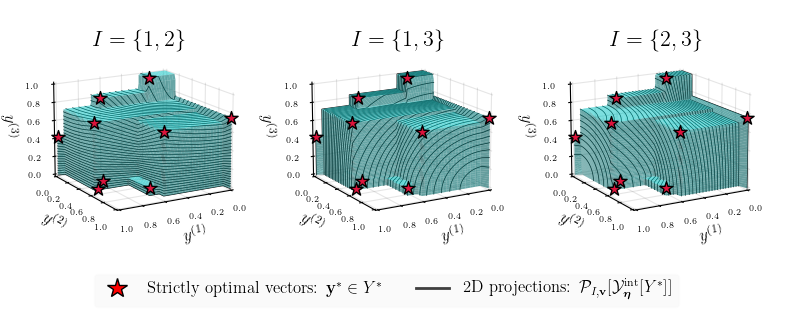

In [4]:
plt.rcParams["grid.color"] = (0.5, 0.5, 0.5, 0.2)
fig, axes = plt.subplots(1, 3, subplot_kw={"projection": "3d"}, figsize=(10, 8))
fig.subplots_adjust(top=0.8, wspace=0, hspace=0)

titles = [r"$I=\{1,2\}$", r"$I=\{1,3\}$", r"$I=\{2,3\}$"]

for i in range(3):
    ax = plt.subplot(1, 3, i + 1)
    surf = ax.plot_surface(
        Z[..., 0],
        Z[..., 1],
        Z[..., 2],
        alpha=0.6,
        rstride=1,
        cstride=1,
        color="cyan",
        shade=True,
    )

    ax.scatter(
        samples[:, 0],
        samples[:, 1],
        samples[:, 2],
        color="crimson",
        s=100,
        zorder=5,
        marker="*",
        depthshade=False,
        edgecolor="k",
        linewidth=1,
        alpha=1,
    )
    ax.set_xlabel(r"$y^{(1)}$", fontsize=12)
    ax.set_ylabel(r"$y^{(2)}$", fontsize=12)
    ax.set_zlabel(r"$y^{(3)}$", fontsize=12)
    ax.set_title(titles[i], fontsize=16, y=0.9)
    ax.view_init(15, 60)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_zlim(0, 1)
    ax.set_box_aspect(aspect=None, zoom=0.79)
    ax.tick_params(axis="both", which="major", labelsize=6)
    # Get rid of colored axes planes.
    # First remove fill.
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    # Now set color to white (or whatever is "invisible").
    ax.xaxis.pane.set_edgecolor("w")
    ax.yaxis.pane.set_edgecolor("w")
    ax.zaxis.pane.set_edgecolor("w")

##########################################################################################
for vals in torch.linspace(0, 1, 40):
    fixed_value = torch.tensor([vals], **tkwargs)
    num_points = 1000

    ones = torch.ones(num_points, **tkwargs)
    unit_vector = UnitVector(num_objectives=2, transform_label="polar")
    t = torch.linspace(0, 1, num_points, **tkwargs).unsqueeze(-1)
    c = torch.sqrt(1 - torch.norm(fixed_value) ** 2)
    weights = c * unit_vector(t)

    w1 = torch.column_stack([weights[:, 0], weights[:, 1], fixed_value * ones])
    w2 = torch.column_stack([weights[:, 0], fixed_value * ones, weights[:, 1]])
    w3 = torch.column_stack([fixed_value * ones, weights[:, 0], weights[:, 1]])

    for i, w in enumerate([w1, w2, w3]):
        ax = plt.subplot(1, 3, i + 1)
        s_fn = LengthScalarization(weights=w, ref_points=nadir)
        projection_line = nadir + s_fn(samples).max(dim=0).values.unsqueeze(-1) * w
        projection_line = projection_line.detach().numpy()
        ax.plot3D(
            projection_line[:, 0],
            projection_line[:, 1],
            projection_line[:, 2],
            color="k",
            alpha=1,
            linewidth=0.5,
        )
##########################################################################################
# Legend.
red_star = mlines.Line2D(
    [],
    [],
    color="red",
    marker="*",
    linestyle="None",
    markersize=15,
    markeredgecolor="k",
    markeredgewidth=1,
    label=r"Strictly optimal vectors: $\mathbf{y}^* \in Y^*$",
)

black_line = mlines.Line2D(
    [],
    [],
    color="k",
    linestyle="-",
    linewidth=2,
    markersize=15,
    markeredgecolor="k",
    markeredgewidth=2,
    alpha=0.75,
    label=r"2D projections: $\mathcal{P}_{I, \mathbf{v}}[\mathcal{Y}_{\boldsymbol{\eta}}^{\text{int}}[Y^*]]$",
)

axes[0].legend(
    handles=[red_star, black_line],
    ncol=3,
    fontsize=12,
    loc=(0.325, -0.15),
    facecolor="k",
    framealpha=0.02,
)

plt.show()